# **Pattern Recognition and Machine Learning (PRML) Project**

####################formatting gicen csv################################

In [156]:
import pandas as pd

# Load and inspect the CSV file to check its structure
file_path = r'C:\Users\sande\Downloads\person.csv\person.csv'


try:
    # Read the file with semicolon delimiter
    fixed_data = pd.read_csv(file_path, delimiter=';')
    fixed_info = fixed_data.info()  # Check the structure after fixing
    fixed_head = fixed_data.head()  # Preview the fixed content
except Exception as e:
    fixed_info = str(e)
    fixed_head = None

fixed_data.to_csv("formatted.csv")
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61110 entries, 0 to 61109
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              61110 non-null  object 
 1   name                            61110 non-null  object 
 2   date_of_birth                   61096 non-null  object 
 3   weight                          60716 non-null  float64
 4   hair                            61109 non-null  object 
 5   sex                             61109 non-null  object 
 6   height                          60728 non-null  float64
 7   race                            61106 non-null  object 
 8   eyes                            61109 non-null  object 
 9   admission_date                  61109 non-null  object 
 10  projected_parole_date           33932 non-null  object 
 11  last_paroled_date               8474 non-null   object 
 12  projected_discharge_date        

In [158]:
# Drop unnecessary columns with mostly null values
columns_to_drop = ['discharge_date', 'Unnamed: 21', 'electronic_detention_date', 'alias']
cleaned_data = fixed_data.drop(columns=columns_to_drop)

# Handle null values in important columns - dropping rows with critical missing data
essential_columns = ['id', 'name', 'date_of_birth', 'weight', 'hair', 'sex', 'height', 'race', 'eyes']
cleaned_data = cleaned_data.dropna(subset=essential_columns)

# Save the cleaned data for review

cleaned_data.to_csv("cleaned and formatted.csv",index=False)

cleaned_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 60713 entries, 0 to 61108
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              60713 non-null  object 
 1   name                            60713 non-null  object 
 2   date_of_birth                   60713 non-null  object 
 3   weight                          60713 non-null  float64
 4   hair                            60713 non-null  object 
 5   sex                             60713 non-null  object 
 6   height                          60713 non-null  float64
 7   race                            60713 non-null  object 
 8   eyes                            60713 non-null  object 
 9   admission_date                  60713 non-null  object 
 10  projected_parole_date           33851 non-null  object 
 11  last_paroled_date               8474 non-null   object 
 12  projected_discharge_date        60701

###########################  Feature extraction using mobilenetv2 #############################################



In [ ]:
import os
import pandas as pd
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Paths
images_path_front = r"C:\Users\sande\Downloads\illinois_doc_dataset\front2\front2"  # Front face images
images_path_side = r"C:\Users\sande\Downloads\illinois_doc_dataset\front2\side2"  # Side face images
csv_path = r"C:\Users\sande\Downloads\illinois_doc_dataset\id_bmi.csv"  # CSV with BMI and Gender data
features_save_dir = r"C:\Users\sande\Downloads\intermediate_features"  # Directory to save intermediate features
image_size = (128, 128)  # Image resizing dimensions
save_interval = 100  # Save every 50 processed rows

# Create directory if it doesn't exist
os.makedirs(features_save_dir, exist_ok=True)

# Load the CSV data
id_bmi = pd.read_csv(csv_path)

# Ensure 'id' column matches image file names
id_bmi['id'] = id_bmi['id'].astype(str) + '.jpg'

# Map gender to binary labels if numeric
if id_bmi['gender'].dtype != object:
    id_bmi['gender'] = id_bmi['gender'].map({0: 'Female', 1: 'Male'})

# Check for missing gender or bmi values and drop them
id_bmi = id_bmi.dropna(subset=['gender', 'bmi'])

id_bmi_sampled = id_bmi.sample(frac=1, random_state=42)  # Sampling

# Initialize the feature extractor (MobileNetV2)
feature_extractor = MobileNetV2(include_top=False, pooling='avg', input_shape=(image_size[0], image_size[1], 3))

# Function to load and preprocess images
def preprocess_image(image_path):
    try:
        img = load_img(image_path, target_size=image_size)  # Load image
        img_array = img_to_array(img) / 255.0  # Convert to array and normalize
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Extract features for both front and side images
features = []
bmi_labels = []  # To store BMI labels
ids = []
gender_labels = []

for idx, (_, row) in enumerate(id_bmi_sampled.iterrows(), start=1):
    img_id = row['id']
    gender = row['gender']
    bmi = row['bmi']  # Extract BMI

    # Front and side image paths
    front_path = os.path.join(images_path_front, img_id)
    side_path = os.path.join(images_path_side, img_id)

    # Preprocess images
    front_img = preprocess_image(front_path)
    side_img = preprocess_image(side_path)

    # Skip if any image is missing or cannot be processed
    if front_img is None or side_img is None:
        continue

    # Extract features using the pre-trained model
    # front_feature = feature_extractor.predict(np.expand_dims(front_img, axis=0))[0]
    # side_feature = feature_extractor.predict(np.expand_dims(side_img, axis=0))[0]

    # Extract features using the pre-trained model
    front_feature = feature_extractor.predict(np.expand_dims(front_img, axis=0), verbose=0)[0]
    side_feature = feature_extractor.predict(np.expand_dims(side_img, axis=0), verbose=0)[0]


    # Combine front and side features
    combined_feature = np.concatenate([front_feature, side_feature])

    # Append features, BMI labels, and ids
    features.append(combined_feature)
    bmi_labels.append(bmi)
    gender_labels.append(gender)
    ids.append(img_id)

    # Save intermediate results at intervals
    if idx % save_interval == 0:
        save_path = os.path.join(features_save_dir, f"features_batch_{idx // save_interval}.npz")
        np.savez(save_path, features=np.array(features), bmi_labels=np.array(bmi_labels), ids=np.array(ids), gender_labels=np.array(gender_labels))
        print(f"\nSaved batch {idx // save_interval} to {save_path}")
        features, bmi_labels, ids, gender_labels = [], [], [], []  # Reset for the next batch

# Save the remaining features
if features:
    save_path = os.path.join(features_save_dir, f"features_batch_final.npz")
    np.savez(save_path, features=np.array(features), bmi_labels=np.array(bmi_labels), ids=np.array(ids), gender_labels=np.array(gender_labels))
    print(f"Saved final batch to {save_path}")


###########################combining all the data into single set ####################################################

In [3]:
import os
import numpy as np

# Paths
features_save_dir = r"C:\Users\sande\Downloads\intermediate_features"  # Directory containing intermediate feature files
final_features_save_path = r"C:\Users\sande\Downloads\combined_face_features_with_bmi.npz"  # Path to save the combined features

# Initialize empty lists to hold concatenated data
all_features = []
all_bmi_labels = []
all_ids = []
all_gender_labels = []

# Iterate through all .npz files in the directory
for file_name in sorted(os.listdir(features_save_dir)):
    if file_name.endswith(".npz"):  # Check if the file is an .npz file
        file_path = os.path.join(features_save_dir, file_name)
        try:
            data = np.load(file_path)
            
            # Append the data from each batch
            all_features.append(data['features'])
            all_bmi_labels.append(data['bmi_labels'])
            all_ids.append(data['ids'])
            all_gender_labels.append(data['gender_labels'])  # Correct key as per saved data
            print(f"Loaded {file_name} successfully.")
        except Exception as e:
            print(f"Error loading {file_name}: {e}")

# Concatenate all the data into single arrays
all_features = np.concatenate(all_features, axis=0)
all_bmi_labels = np.concatenate(all_bmi_labels, axis=0)
all_ids = np.concatenate(all_ids, axis=0)
all_gender_labels = np.concatenate(all_gender_labels, axis=0)

# Save the combined dataset
np.savez(
    final_features_save_path,
    features=all_features,
    bmi_labels=all_bmi_labels,
    ids=all_ids,
    gender_labels=all_gender_labels,
)

print(f"Combined features saved to {final_features_save_path}")


Loaded features_batch_1.npz successfully.
Loaded features_batch_10.npz successfully.
Loaded features_batch_100.npz successfully.
Loaded features_batch_101.npz successfully.
Loaded features_batch_102.npz successfully.
Loaded features_batch_103.npz successfully.
Loaded features_batch_104.npz successfully.
Loaded features_batch_105.npz successfully.
Loaded features_batch_106.npz successfully.
Loaded features_batch_107.npz successfully.
Loaded features_batch_108.npz successfully.
Loaded features_batch_109.npz successfully.
Loaded features_batch_11.npz successfully.
Loaded features_batch_110.npz successfully.
Loaded features_batch_111.npz successfully.
Loaded features_batch_112.npz successfully.
Loaded features_batch_113.npz successfully.
Loaded features_batch_114.npz successfully.
Loaded features_batch_115.npz successfully.
Loaded features_batch_116.npz successfully.
Loaded features_batch_117.npz successfully.
Loaded features_batch_118.npz successfully.
Loaded features_batch_119.npz succes

########################using PCA to reduce dimentionality########################################

In [1]:
from sklearn.decomposition import PCA
import numpy as np

# Load the features file
features_save_path = r"C:\Users\sande\Downloads\combined_face_features_with_bmi.npz"
pca_features_save_path = r"C:\Users\sande\Downloads\face_features_with_bmi_pca.npz"

data = np.load(features_save_path)

# Extract features, labels, and IDs
features = data['features']
bmi_labels = data['bmi_labels']
ids = data['ids']
gender_lables=data["gender_labels"]

# Apply PCA
n_components = 500  # Number of principal components to retain
pca = PCA(n_components=n_components)

# Fit PCA to the features
pca_features = pca.fit_transform(features)


# Save PCA-transformed features, along with labels and IDs
np.savez(pca_features_save_path, features=pca_features, bmi_labels=bmi_labels, ids=ids,gender_lables=gender_lables)
print(f"PCA-transformed features saved to {pca_features_save_path}")

# Display shapes
print("Original Features Shape:", features.shape)
print("PCA Features Shape:", pca_features.shape)


# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("\nExplained Variance Ratio (First 5 Components):", explained_variance_ratio[:5])
print("Cumulative Explained Variance:", np.cumsum(explained_variance_ratio)[-1])



PCA-transformed features saved to C:\Users\sande\Downloads\face_features_with_bmi_pca.npz
Original Features Shape: (60001, 2560)
PCA Features Shape: (60001, 500)

Explained Variance Ratio (First 5 Components): [0.06688548 0.05082562 0.03962915 0.03528755 0.03194137]
Cumulative Explained Variance: 0.89077175


###############################gender prediction using logistic regression ####################################################

3. Estimate the gender based on the facial features

In [3]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle

# Paths
pca_features_save_path = r"C:\Users\sande\Downloads\face_features_with_bmi_pca.npz"
model_save_path = r"C:\Users\sande\Downloads\illinois_doc_dataset\front2\gender_prediction_model.pkl"

# Load PCA-transformed features
data = np.load(pca_features_save_path)
features = data['features']
labels = data['gender_lables']

# Encode labels to binary (if needed)
labels_binary = (labels == 'Male').astype(int)  # Convert 'male' to 1 and 'female' to 0

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels_binary, test_size=0.2, random_state=88)

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Separate test samples by gender
X_test_male = X_test[y_test == 1]
X_test_female = X_test[y_test == 0]

# Take an equal number of male and female samples
n_samples = min(len(X_test_male), len(X_test_female))
X_test_balanced = np.vstack((X_test_male[:n_samples], X_test_female[:n_samples]))
y_test_balanced = np.hstack((np.ones(n_samples), np.zeros(n_samples)))

# Make predictions on the balanced test set
y_pred_balanced = model.predict(X_test_balanced)

# Evaluate the balanced accuracy
balanced_accuracy = accuracy_score(y_test_balanced, y_pred_balanced)
print(f"Balanced Gender Prediction Accuracy: {balanced_accuracy:.2f}")

# Save the trained model
with open(model_save_path, 'wb') as model_file:
    pickle.dump(model, model_file)
print(f"Model saved to {model_save_path}")

# Test model on new data
test_sample = X_test[0].reshape(1, -1)  # Example test case
predicted_gender = 'Male' if model.predict(test_sample)[0] == 1 else 'Female'
print(f"Predicted Gender for Test Sample: {predicted_gender}")


Balanced Gender Prediction Accuracy: 0.97
Model saved to C:\Users\sande\Downloads\illinois_doc_dataset\front2\gender_prediction_model.pkl
Predicted Gender for Test Sample: Male


############################### bmi prediction using linear regression ####################################################
1. Predict the Body Mass Index (BMI) using the facial images (frontal and side view) with 80-20 split.
Use 80% for training and 20% for testing.

In [5]:
import numpy as np
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
import pickle
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# Paths
pca_features_save_path = r"C:\Users\sande\Downloads\face_features_with_bmi_pca.npz"
model_save_path = r"C:\Users\sande\Downloads\illinois_doc_dataset\front2\gender_prediction_model.pkl"

# Load PCA-transformed features
data = np.load(pca_features_save_path)
features = data['features']
labels = data['bmi_labels']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=88)

# Train a Linear Regression model to predict BMI
model = LinearRegression()
# model = GradientBoostingRegressor(random_state=88)
# model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)



5. The Metrics to be used are: MAE, MSE, R2, and Pearson Coefficient

In [21]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
from scipy.stats import pearsonr
pearson_corr,_= pearsonr(y_test, y_pred)

print(f"BMI Prediction Metrics:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Pearson corr: {pearson_corr:.2f}")

# Save the trained BMI prediction model
with open(model_save_path, 'wb') as model_file:
    pickle.dump(model, model_file)
print(f"BMI Prediction Model saved to {model_save_path}")

# Test the model on a new sample
test_sample = X_test[0].reshape(1, -1)  # Example test case
predicted_bmi = model.predict(test_sample)
print(f"Predicted BMI for Test Sample: {predicted_bmi[0]:.2f}")



BMI Prediction Metrics:
Mean Squared Error: 17.84
Mean Absolute Error: 3.15
R² Score: 0.35
Pearson corr: 0.59
BMI Prediction Model saved to C:\Users\sande\Downloads\illinois_doc_dataset\front2\gender_prediction_model.pkl
Predicted BMI for Test Sample: 25.75


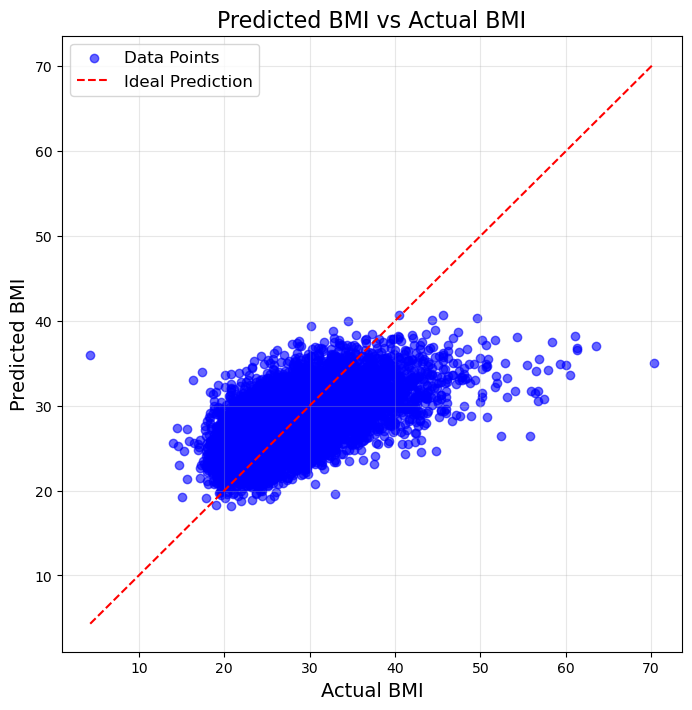

In [23]:
import matplotlib.pyplot as plt

# Scatter plot for actual vs predicted BMI
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Data Points')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Prediction')

# Add labels, title, and legend
plt.xlabel('Actual BMI', fontsize=14)
plt.ylabel('Predicted BMI', fontsize=14)
plt.title('Predicted BMI vs Actual BMI', fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.show()


###############4. Grade them based on the BMI as Underweight, Normal and Overweight (Obese)###############

In [9]:
import numpy as np

# Example y_pred array
y_pred   # Replace this with your actual predictions

# BMI grading function
def grade_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 24.9:
        return "Normal"
    elif 25 <= bmi < 29.9:
        return "Overweight"
    else:
        return "Obese"

# Grade each BMI in y_pred
bmi_grades = [grade_bmi(bmi) for bmi in y_pred]

# Print results
for i, (bmi, grade) in enumerate(zip(y_pred, bmi_grades)):
    print(f"Inmate {i+1}: BMI = {bmi:.2f}, Grade = {grade}")


Inmate 1: BMI = 25.75, Grade = Overweight
Inmate 2: BMI = 30.77, Grade = Obese
Inmate 3: BMI = 24.30, Grade = Normal
Inmate 4: BMI = 27.59, Grade = Overweight
Inmate 5: BMI = 33.58, Grade = Obese
Inmate 6: BMI = 25.68, Grade = Overweight
Inmate 7: BMI = 29.47, Grade = Overweight
Inmate 8: BMI = 29.75, Grade = Overweight
Inmate 9: BMI = 26.67, Grade = Overweight
Inmate 10: BMI = 27.20, Grade = Overweight
Inmate 11: BMI = 29.67, Grade = Overweight
Inmate 12: BMI = 20.38, Grade = Normal
Inmate 13: BMI = 25.72, Grade = Overweight
Inmate 14: BMI = 30.28, Grade = Obese
Inmate 15: BMI = 29.60, Grade = Overweight
Inmate 16: BMI = 28.01, Grade = Overweight
Inmate 17: BMI = 27.69, Grade = Overweight
Inmate 18: BMI = 24.05, Grade = Normal
Inmate 19: BMI = 31.16, Grade = Obese
Inmate 20: BMI = 27.93, Grade = Overweight
Inmate 21: BMI = 32.41, Grade = Obese
Inmate 22: BMI = 33.50, Grade = Obese
Inmate 23: BMI = 22.18, Grade = Normal
Inmate 24: BMI = 25.76, Grade = Overweight
Inmate 25: BMI = 29.14,

6. Plot the distribution of offences that the inmates have done.

In [11]:
import pandas as pd


fixed_data = pd.read_csv("sentencing.csv", delimiter=';')
fixed_data[["id","offense"]].to_csv("formatted_s.csv")


for i in fixed_data["offense"].unique():
    print(i)


AGGR KIDNAPPING-NO RANSOM
ATTEMPT MURDER/INTENT TO KILL/INJURE
RAPE
BURGLARY
ATTEMPT BURGLARY
ROBBERY
ARMED ROBBERY
OBSTRUCTING JUSTICE
CARRY/POSS FIREARM/PUBLIC/SCH
MURDER/INTENT TO KILL/INJURE
THEFT CONTROL INTENT 10K<100K
RET THEFT/DISP MERCH/<$150/2+
RETAIL THEFT/RETURN>$150
RET THEFT/DISPLAY MERCH/>$150
THEFT/CON/PRIOR CONVIC <300
AGG BATTERY/HARM MERCHANT
THEFT/UNAUTHD CON/>10K <100K
THEFT >$10K-$100K
POSS AMT CON SUB EXCEPT(A)/(D)
FELON POSS/USE WEAPON/FIREARM
THEFT >$300-$10K
AGG CRIM SEX ASSAULT/WEAPON
AGG CRIM SEX ASLT/BODILY HARM
ATTEMPT ARMED ROBBERY
CONSP MURDER/INTENT TO KILL/INJURE
AGG BATTERY/GREAT BODILY HARM
ATTEMPT (THEFT)
CARRY/POSSESS FIREARM/2ND&SUBQ
CONT SUBS ACT-MFG/DEL
BATTERY
MURDER/OTHER FORCIBLE FELONY
OTHER AMT NARCOTIC SCHED I&II
AID/ABET/POSS/SELL STOLEN VEH
DEVIATE SEXUAL ASSAULT
MANU/DEL 01-15 GR COCAINE/ANLG
FELON POSS/USE FIREARM PRIOR
AMT NARC SCHED I/II/SCH/HS/PK
CONT SUBS ACT-UNAUTH POSS
CONT SUBS ACT-MFG/DEL/ENHANCED
VOL MANSLAUGHTER/PRIOR 1/1/82


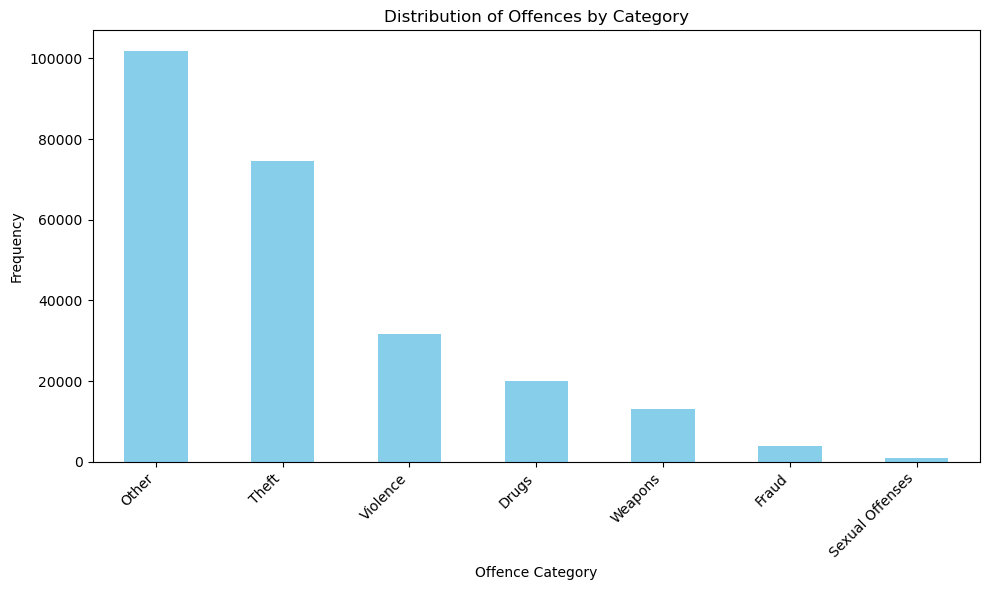

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('formatted_s.csv')

# Define offence categories
category_dict = {
    'Theft': ['BURGLARY', 'ROBBERY', 'THEFT', 'RETAIL THEFT', 'HOME INVASION', 'THEFT CONTROL INTENT'],
    'Violence': ['MURDER', 'ASSAULT', 'BATTERY', 'RAPE', 'KIDNAP', 'DOMESTIC BATTERY'],
    'Drugs': ['NARCOTIC', 'COCAINE', 'METH', 'DRUG', 'POSSESSION OF DRUGS'],
    'Weapons': ['ARMED ROBBERY', 'FELON POSSESS WEAPON', 'FIREARM', 'CARRY FIREARM'],
    'Sexual Offenses': ['SEXUAL ASSAULT', 'SEXUAL ABUSE', 'CHILD PORN'],
    'Fraud': ['FORGERY', 'IDENTITY THEFT', 'BAD CHECK', 'FRAUD'],
    'Other': ['ESCAPE', 'OBSTRUCTION', 'PERJURY', 'INTIMIDATION']
}

# Function to categorize offences
def categorize_offence(offence):
    offence_lower = offence.lower()  # Convert to lowercase for case-insensitive matching
    for category, offences in category_dict.items():
        if any(off.lower() in offence_lower for off in offences):  # Match keywords case-insensitively
            return category
    return 'Other'  # default to 'Other' if no match found

# Apply categorization
df['offence_category'] = df['offense'].apply(categorize_offence)

# Count occurrences in each category
category_counts = df['offence_category'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Offences by Category')
plt.xlabel('Offence Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


2. Test the model with your face and your friend’s face to estimate BMI value.

In [31]:
import os
import pandas as pd
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Paths
images_path_front = r"C:\Users\sande\Downloads\illinois_doc_dataset\front2\front.jpg"  # Front face image
images_path_side = r"C:\Users\sande\Downloads\illinois_doc_dataset\front2\side.jpg"  # Side face image
image_size = (128, 128)  # Image resizing dimensions


# Initialize the feature extractor (MobileNetV2)
feature_extractor = MobileNetV2(include_top=False, pooling='avg', input_shape=(image_size[0], image_size[1], 3))

# Function to load and preprocess images
def preprocess_image(image_path):
    try:
        img = load_img(image_path, target_size=image_size)  # Load image
        img_array = img_to_array(img) / 255.0  # Convert to array and normalize
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Preprocess front and side images
front_img = preprocess_image(images_path_front)
side_img = preprocess_image(images_path_side)


if front_img is None or side_img is None:
    print("Error: One or both images are missing or could not be processed.")
else:
    # Extract features using the pre-trained model
    front_feature = feature_extractor.predict(np.expand_dims(front_img, axis=0), verbose=0)[0]
    side_feature = feature_extractor.predict(np.expand_dims(side_img, axis=0), verbose=0)[0]

    # Combine front and side features
    combined_feature = np.concatenate([front_feature, side_feature])
    

me=pca.transform(np.array([combined_feature]))

print("Data Features of friend:\n",me)


Data Features of friend:
 [[ 4.77647018e+00  1.01465826e+01  2.23425436e+00 -2.66848969e+00
  -8.99538279e-01 -1.03199673e+00 -1.06309330e+00 -4.86240864e+00
   1.32119548e+00  3.37334484e-01  3.79953456e+00 -1.83527839e+00
   3.59129381e+00 -2.89590716e+00 -4.72158384e+00  7.36445713e+00
   1.25863814e+00 -2.37842369e+00 -4.95086575e+00  1.18867946e+00
   1.78322124e+00  1.08977568e+00 -1.66319442e+00 -9.73522365e-02
  -2.66110611e+00  2.62564325e+00  3.96163106e+00 -1.45722580e+00
  -1.20043480e+00 -7.08170772e-01  1.37909722e+00 -1.61514366e+00
  -2.74011511e-02  1.19345748e+00  1.36954236e+00 -9.49121825e-03
   7.58355379e-01  5.60220256e-02 -3.48732805e+00 -1.44428468e+00
  -8.68531704e-01 -2.25408101e+00 -7.72670746e-01  1.11193800e+00
   1.09637809e+00  2.94086671e+00 -2.44896814e-01 -8.34347606e-01
   1.48178148e+00 -1.91887200e+00  1.34042096e+00 -1.73204362e+00
  -1.20969379e+00  3.64148974e+00 -1.85480762e+00  1.03531528e+00
   6.43159151e-02 -1.38113976e-01 -1.53648877e+00 

In [17]:
model.predict(me)

array([30.069412], dtype=float32)

In [19]:
grade_bmi(model.predict(me))

'Obese'